# PTM PPI Shortcut analysis

In [1]:
import sys, pandas as pd, os, matplotlib.pyplot as plt, sklearn
from sklearn import tree

sys.path.append("../src")

all_labels = list(range(7))
pos_labels = list(range(1,7,1))
label_names = ["other",
                            "phosphorylation",
                            "dephosphorylation",
                            "methylation",
                            "ubiquitination",
                            "acetylation",
                            "deubiquitination"]

renamed_labels = ["Negative"] + [i.title() for i in label_names[1:]]

ptm_trigger_words =  ["phosphorylation", "deubiquitination", "acetylation", "ubiquitination", "methylation", "dephosphorylation"]



## Original inputs with markers
For how to create the preprocessed file for PTM-PPI, see https://github.com/elangovana/large-scale-ptm-ppi/blob/main/src/utils/static_markers_ppi_multiclass.py

In [2]:
temp_dir = "temp"

In [3]:
trainfile="../temp/markers_train_multiclass.json"
testfile="../temp/markers_test_multiclass.json"
valfile="../temp/markers_val_multiclass.json"


## Predictions with markers

In [4]:
largescalefile = "../temp/markers_largescale_hq_above_threshold.json"
largescale_low_hq="../temp/markers_largescale_lq_below_threshold.json"

test_predictions_file ="../temp/markers_test_pred_multiclass.json"

In [5]:
def load_large_scale(file, labels_order = label_names):
    df = pd.read_json(file, orient="records")
    df["y"] = df["prediction"].apply(lambda x: labels_order.index(x) )
    df["y_raw"] = df["prediction"]


    return df

def load_valtest_ensemble_pred(file, labels_order = label_names):
    df = pd.read_json(file, orient="records")
    df["y"] = df["prediction"].apply(lambda x: labels_order.index(x) )
    df["y_raw"] = df["prediction"]


    return df

In [6]:
from model_nb_relation_classifier import ModelNBRelationClassifier
from model_nb_tree_relation_classifier import ModelNBTreeRelationClassifier
from model_tree_relation_classifier import ModelTreeRelationClassifier

NAIVE_BAYES="Naive Bayes"
NAIVE_BAYES_WITH_TREE = "Naive Bayes + Tree"
TREE = "Tree"

def  train_and_predict_all_classifiers(df, min_df=None):
    max_words_per_class = 10
    
    classifiers = {
        NAIVE_BAYES : ModelNBRelationClassifier("PROTPART1", "PROTPART0", max_words_per_class=max_words_per_class, min_df=min_df),
        NAIVE_BAYES_WITH_TREE : ModelNBTreeRelationClassifier("PROTPART1", "PROTPART0", min_df=min_df, max_words_per_class=max_words_per_class, trigger_words=ptm_trigger_words),
        TREE : ModelTreeRelationClassifier("PROTPART1", "PROTPART0",  trigger_words=ptm_trigger_words)

    }
    
    result = {}
    for k, m in classifiers.items():
        
        print(f"Training {k}")
        
        m.train(df["x"], df["y"])
        p, p_conf = m.predict(df["x"])
        result[k] = {
            "m" : m,
            "predictions" : p,
            "predictions_conf": p_conf
        }
    return result


In [7]:
def isint(a):
    try:
        t = int(a)
        return True
    except:
        return False
    
def float_percent_format(x):
     return "{:.1f}".format(x*100)

def int_format(x):
     return str(int(x))

def print_report(actual, pred, labels=None, label_names = renamed_labels):

    pos_f1 = sklearn.metrics.f1_score(actual, pred, labels=labels, average='micro',
                                  sample_weight=None, zero_division=0)
    all_f1 = sklearn.metrics.f1_score(actual, pred, average='micro', sample_weight=None, zero_division=0)
    
        
    d = sklearn.metrics.classification_report(actual,
                                            pred,
                                            output_dict=True,
                                            labels=labels,zero_division=0)
    df =  pd.DataFrame(d).T
    df.index = list(map(lambda x: label_names[int(x)] if isint( x) else x, df.index))

    return df
    
def print_report_all_classifiers(actual, results_dict, *args, **kwargs):
    result = []
    for k, v in results_dict.items():
        df = print_report(actual,v["predictions"],  *args, **kwargs)
        df.insert (0, "model", k)
        
        result.append(df)
    df = pd.concat(result)
    df.insert(1, "index", df.index)
    print(df.to_latex(index=False, formatters = {"precision": float_percent_format, "recall":float_percent_format, "f1-score":float_percent_format,"support":int_format }))
    return df
        
        

In [8]:
def plot_tree(m):
    _, ax = plt.subplots(1,1, figsize=(45,15))

    tree.plot_tree(m.tree_model, ax=ax, fontsize=10, feature_names=m.feature_names)

    plt.show()

In [9]:
def get_top_discrimintary_keywords(model, label_index ) :
    index_to_vocab = {i:v  for v,i in model.vocab.items()}

    return sorted( [ (index_to_vocab[i],p) for i,p in enumerate(model.nb_model.feature_log_prob_[label_index])], 
           reverse=True, key=lambda x: x[1])[:50]




In [10]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


def consolidate_label_names(actual, pred, label_names):
    label_indices = list(set(actual).union(pred))
    return [label_names[i] for i in sorted(label_indices)]

def plot_confusionmatrix(y_true,y_pred):
    cm = confusion_matrix(y_true,y_pred)
    labels = consolidate_label_names( y_true,y_pred,label_names)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels = labels)
    disp.plot(cmap="PuBu", xticks_rotation="vertical")
    

## Train GT Train predictions

In [27]:
df_train = pd.read_json(trainfile, orient="records")
train_result = train_and_predict_all_classifiers(df_train)

print_report_all_classifiers(df_train["y"], train_result,  pos_labels)

print_report_all_classifiers(df_train["y"], train_result,  all_labels)



Training Naive Bayes
Max words :  29
Training Naive Bayes + Tree
(1305, 11)
(1305, 11)
Training Tree
(1305, 10)
(1305, 10)
\begin{tabular}{llrrrr}
\toprule
             model &             index & precision & recall & f1-score & support \\
\midrule
       Naive Bayes &   Phosphorylation &      35.2 &   64.0 &     45.4 &     139 \\
       Naive Bayes & Dephosphorylation &      17.6 &   32.1 &     22.8 &      28 \\
       Naive Bayes &       Methylation &      31.2 &  100.0 &     47.6 &      10 \\
       Naive Bayes &    Ubiquitination &      27.8 &  100.0 &     43.5 &       5 \\
       Naive Bayes &       Acetylation &      15.2 &  100.0 &     26.3 &       5 \\
       Naive Bayes &  Deubiquitination &      33.3 &  100.0 &     50.0 &       2 \\
       Naive Bayes &         micro avg &      30.5 &   63.5 &     41.2 &     189 \\
       Naive Bayes &         macro avg &      26.7 &   82.7 &     39.3 &     189 \\
       Naive Bayes &      weighted avg &      31.6 &   63.5 &     41.7 &     18

,model,index,precision,recall,f1-score,support
Negative,Naive Bayes,Negative,0.951754,0.777778,0.856016,1116.000000
Phosphorylation,Naive Bayes,Phosphorylation,0.351779,0.640288,0.454082,139.000000
Dephosphorylation,Naive Bayes,Dephosphorylation,0.176471,0.321429,0.227848,28.000000
Methylation,Naive Bayes,Methylation,0.312500,1.000000,0.476190,10.000000
Ubiquitination,Naive Bayes,Ubiquitination,0.277778,1.000000,0.434783,5.000000
Acetylation,Naive Bayes,Acetylation,0.151515,1.000000,0.263158,5.000000
Deubiquitination,Naive Bayes,Deubiquitination,0.333333,1.000000,0.500000,2.000000
accuracy,Naive Bayes,accuracy,0.757088,0.757088,0.757088,0.757088
macro avg,Naive Bayes,macro avg,0.365019,0.819928,0.458868,1305.000000
weighted avg,Naive Bayes,weighted avg,0.859720,0.757088,0.792385,1305.000000


## Val GT predictions


In [12]:
df_val = pd.read_json(valfile, orient="records")
result_val = train_and_predict_all_classifiers(df_val, min_df=1)

print_report_all_classifiers(df_val["y"], result_val,  pos_labels)

print_report_all_classifiers(df_val["y"], result_val,  all_labels)



Training Naive Bayes
Max words :  41
Training Naive Bayes + Tree
(200, 11)
(200, 11)
Training Tree
(200, 10)
(200, 10)
\begin{tabular}{llrrrr}
\toprule
             model &             index & precision & recall & f1-score & support \\
\midrule
       Naive Bayes &   Phosphorylation &      36.2 &   81.0 &     50.0 &      21 \\
       Naive Bayes & Dephosphorylation &      29.0 &   90.0 &     43.9 &      10 \\
       Naive Bayes &       Methylation &      16.7 &  100.0 &     28.6 &       1 \\
       Naive Bayes &    Ubiquitination &      16.7 &  100.0 &     28.6 &       1 \\
       Naive Bayes &       Acetylation &      33.3 &  100.0 &     50.0 &       1 \\
       Naive Bayes &  Deubiquitination &       0.0 &    0.0 &      0.0 &       0 \\
       Naive Bayes &         micro avg &      31.2 &   85.3 &     45.7 &      34 \\
       Naive Bayes &         macro avg &      22.0 &   78.5 &     33.5 &      34 \\
       Naive Bayes &      weighted avg &      32.8 &   85.3 &     46.9 &      34 \\

,model,index,precision,recall,f1-score,support
Negative,Naive Bayes,Negative,0.953271,0.614458,0.747253,166.0
Phosphorylation,Naive Bayes,Phosphorylation,0.361702,0.809524,0.500000,21.0
Dephosphorylation,Naive Bayes,Dephosphorylation,0.290323,0.900000,0.439024,10.0
Methylation,Naive Bayes,Methylation,0.166667,1.000000,0.285714,1.0
Ubiquitination,Naive Bayes,Ubiquitination,0.166667,1.000000,0.285714,1.0
Acetylation,Naive Bayes,Acetylation,0.333333,1.000000,0.500000,1.0
Deubiquitination,Naive Bayes,Deubiquitination,0.000000,0.000000,0.000000,0.0
micro avg,Naive Bayes,micro avg,0.655000,0.655000,0.655000,200.0
macro avg,Naive Bayes,macro avg,0.324566,0.760569,0.393958,200.0
weighted avg,Naive Bayes,weighted avg,0.847043,0.655000,0.700028,200.0


## Test 

### Predict Test on Test GT fit

In [13]:
df_test = pd.read_json(testfile, orient="records")
result_test_gt = train_and_predict_all_classifiers(df_test, min_df=1)

# df_test["train_shortcut_pred"] = m.predict(df_test["x"])[0]
print_report_all_classifiers(df_test["y"], result_test_gt,  pos_labels)

print_report_all_classifiers(df_test["y"], result_test_gt, all_labels)

l_test_gt = print_report_all_classifiers(df_test["y"], result_test_gt,  pos_labels)


Training Naive Bayes
Max words :  31
Training Naive Bayes + Tree
(352, 11)
(352, 11)
Training Tree
(352, 10)
(352, 10)
\begin{tabular}{llrrrr}
\toprule
             model &             index & precision & recall & f1-score & support \\
\midrule
       Naive Bayes &   Phosphorylation &      45.2 &   63.6 &     52.8 &      44 \\
       Naive Bayes & Dephosphorylation &      19.2 &   83.3 &     31.2 &       6 \\
       Naive Bayes &       Methylation &      22.2 &  100.0 &     36.4 &       4 \\
       Naive Bayes &    Ubiquitination &      16.7 &  100.0 &     28.6 &       1 \\
       Naive Bayes &       Acetylation &       8.3 &  100.0 &     15.4 &       1 \\
       Naive Bayes &  Deubiquitination &       0.0 &    0.0 &      0.0 &       0 \\
       Naive Bayes &         micro avg &      31.5 &   69.6 &     43.3 &      56 \\
       Naive Bayes &         macro avg &      18.6 &   74.5 &     27.4 &      56 \\
       Naive Bayes &      weighted avg &      39.6 &   69.6 &     48.2 &      56 \\

### Predict Test on Test Prediction fit 

Training Naive Bayes
Max words :  34
Training Naive Bayes + Tree
(352, 11)
(352, 11)
Training Tree
(352, 10)
(352, 10)


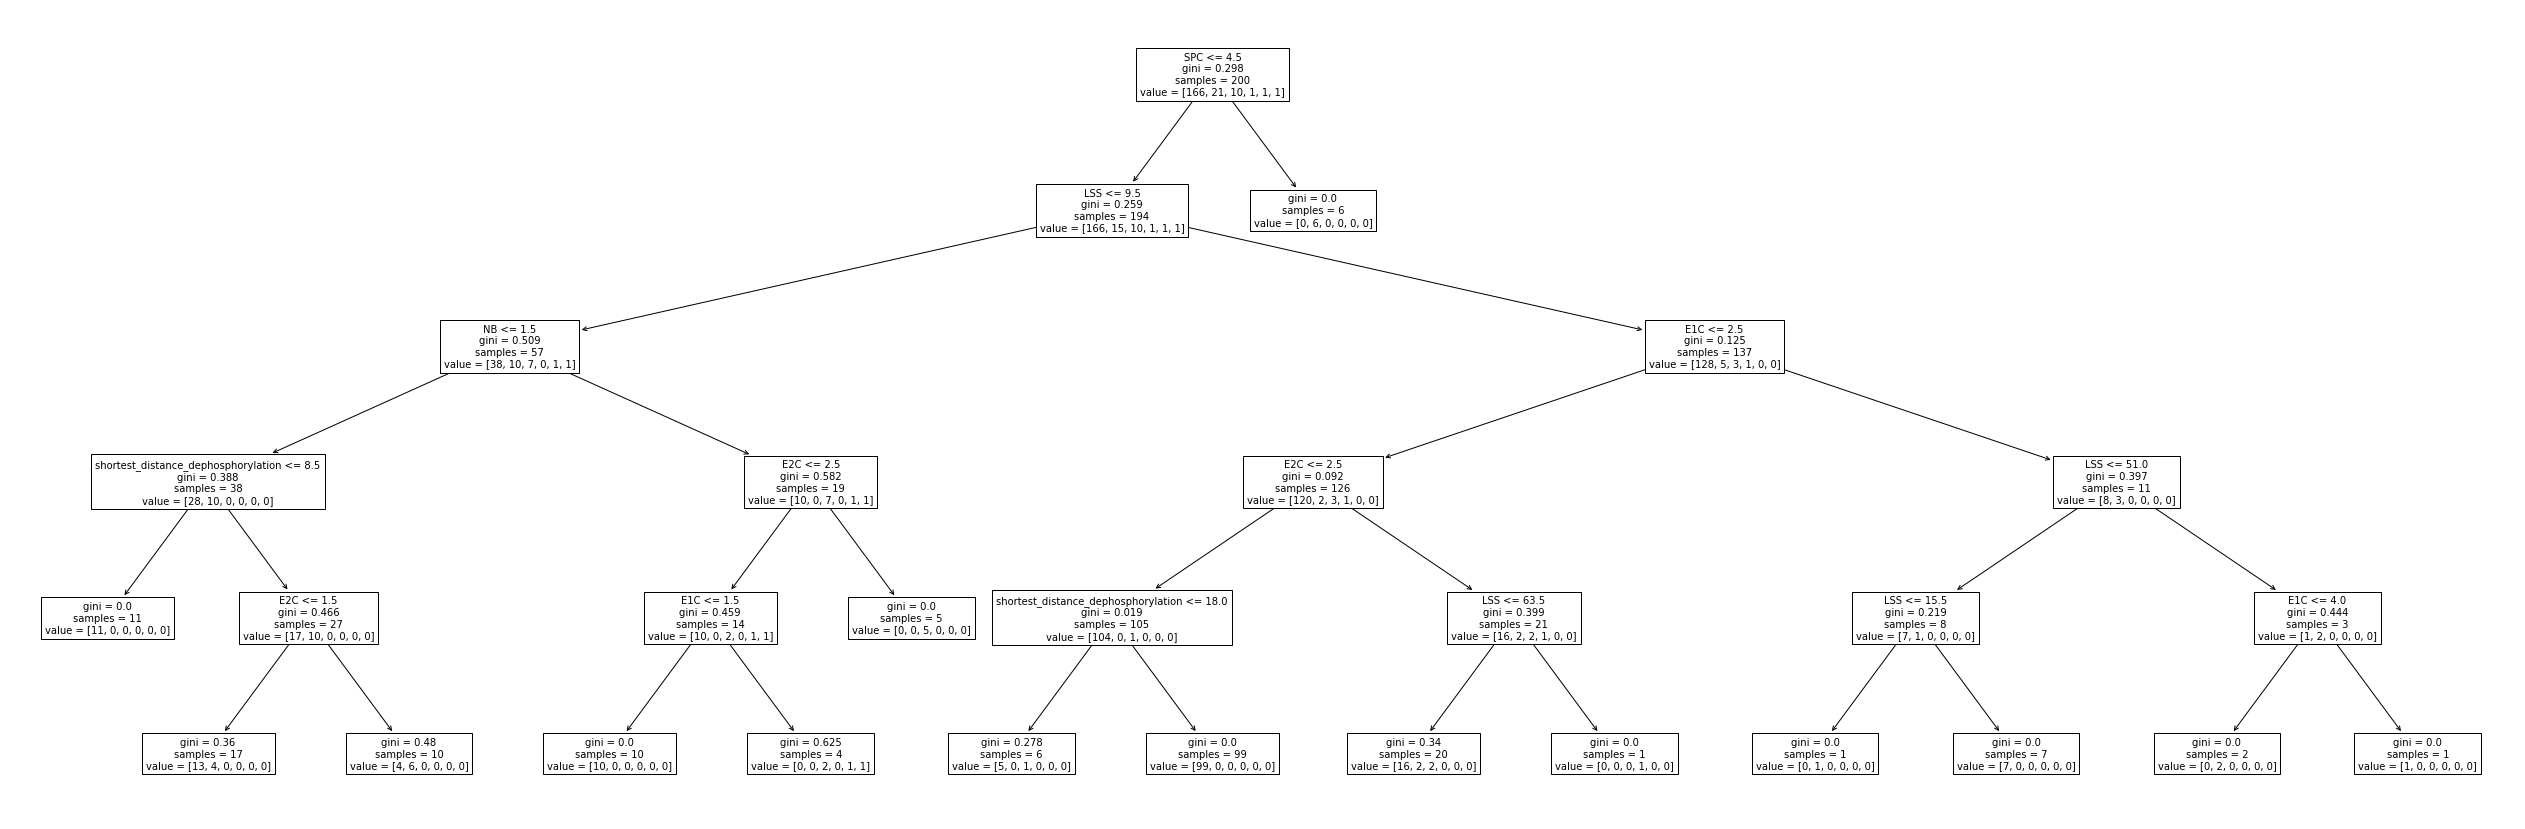

\begin{tabular}{llrrrr}
\toprule
             model &             index & precision & recall & f1-score & support \\
\midrule
       Naive Bayes &   Phosphorylation &      40.0 &   91.7 &     55.7 &      24 \\
       Naive Bayes & Dephosphorylation &      15.4 &  100.0 &     26.7 &       2 \\
       Naive Bayes &       Methylation &      40.0 &  100.0 &     57.1 &       4 \\
       Naive Bayes &    Ubiquitination &       0.0 &    0.0 &      0.0 &       0 \\
       Naive Bayes &       Acetylation &       8.3 &  100.0 &     15.4 &       1 \\
       Naive Bayes &  Deubiquitination &       0.0 &    0.0 &      0.0 &       0 \\
       Naive Bayes &         micro avg &      32.2 &   93.5 &     47.9 &      31 \\
       Naive Bayes &         macro avg &      17.3 &   65.3 &     25.8 &      31 \\
       Naive Bayes &      weighted avg &      37.4 &   93.5 &     52.7 &      31 \\
Naive Bayes + Tree &   Phosphorylation &      80.0 &   83.3 &     81.6 &      24 \\
Naive Bayes + Tree & Dephosphoryla

In [14]:
df_test_prediction = load_valtest_ensemble_pred(test_predictions_file)

result_test_bp = train_and_predict_all_classifiers(df_test_prediction, min_df=1)

plot_tree(result[NAIVE_BAYES_WITH_TREE]["m"])
print_report_all_classifiers(df_test_prediction["y"], result_test_bp,  pos_labels)

print_report_all_classifiers(df_test_prediction["y"], result_test_bp, all_labels)



l_test_pred =  print_report_all_classifiers(df_test_prediction["y"], result_test_bp,  pos_labels)


In [15]:
t = l_test_pred.merge(l_test_gt,  on =["model", "index"])

print(t.to_latex(index=False, float_format= lambda x: f"{x:.1%}").replace("\%",""))

\begin{tabular}{llrrrrrrrr}
\toprule
             model &             index &  precision\_x &  recall\_x &  f1-score\_x &  support\_x &  precision\_y &  recall\_y &  f1-score\_y &  support\_y \\
\midrule
       Naive Bayes &   Phosphorylation &        40.0 &     91.7 &       55.7 &    2400.0 &        45.2 &     63.6 &       52.8 &    4400.0 \\
       Naive Bayes & Dephosphorylation &        15.4 &    100.0 &       26.7 &     200.0 &        19.2 &     83.3 &       31.2 &     600.0 \\
       Naive Bayes &       Methylation &        40.0 &    100.0 &       57.1 &     400.0 &        22.2 &    100.0 &       36.4 &     400.0 \\
       Naive Bayes &    Ubiquitination &         0.0 &      0.0 &        0.0 &       0.0 &        16.7 &    100.0 &       28.6 &     100.0 \\
       Naive Bayes &       Acetylation &         8.3 &    100.0 &       15.4 &     100.0 &         8.3 &    100.0 &       15.4 &     100.0 \\
       Naive Bayes &  Deubiquitination &         0.0 &      0.0 &        0.0 &       0

## Fit large scale hq

Training Naive Bayes
Max words :  27
Training Naive Bayes + Tree
(5794, 11)
(5794, 11)
Training Tree
(5794, 10)
(5794, 10)


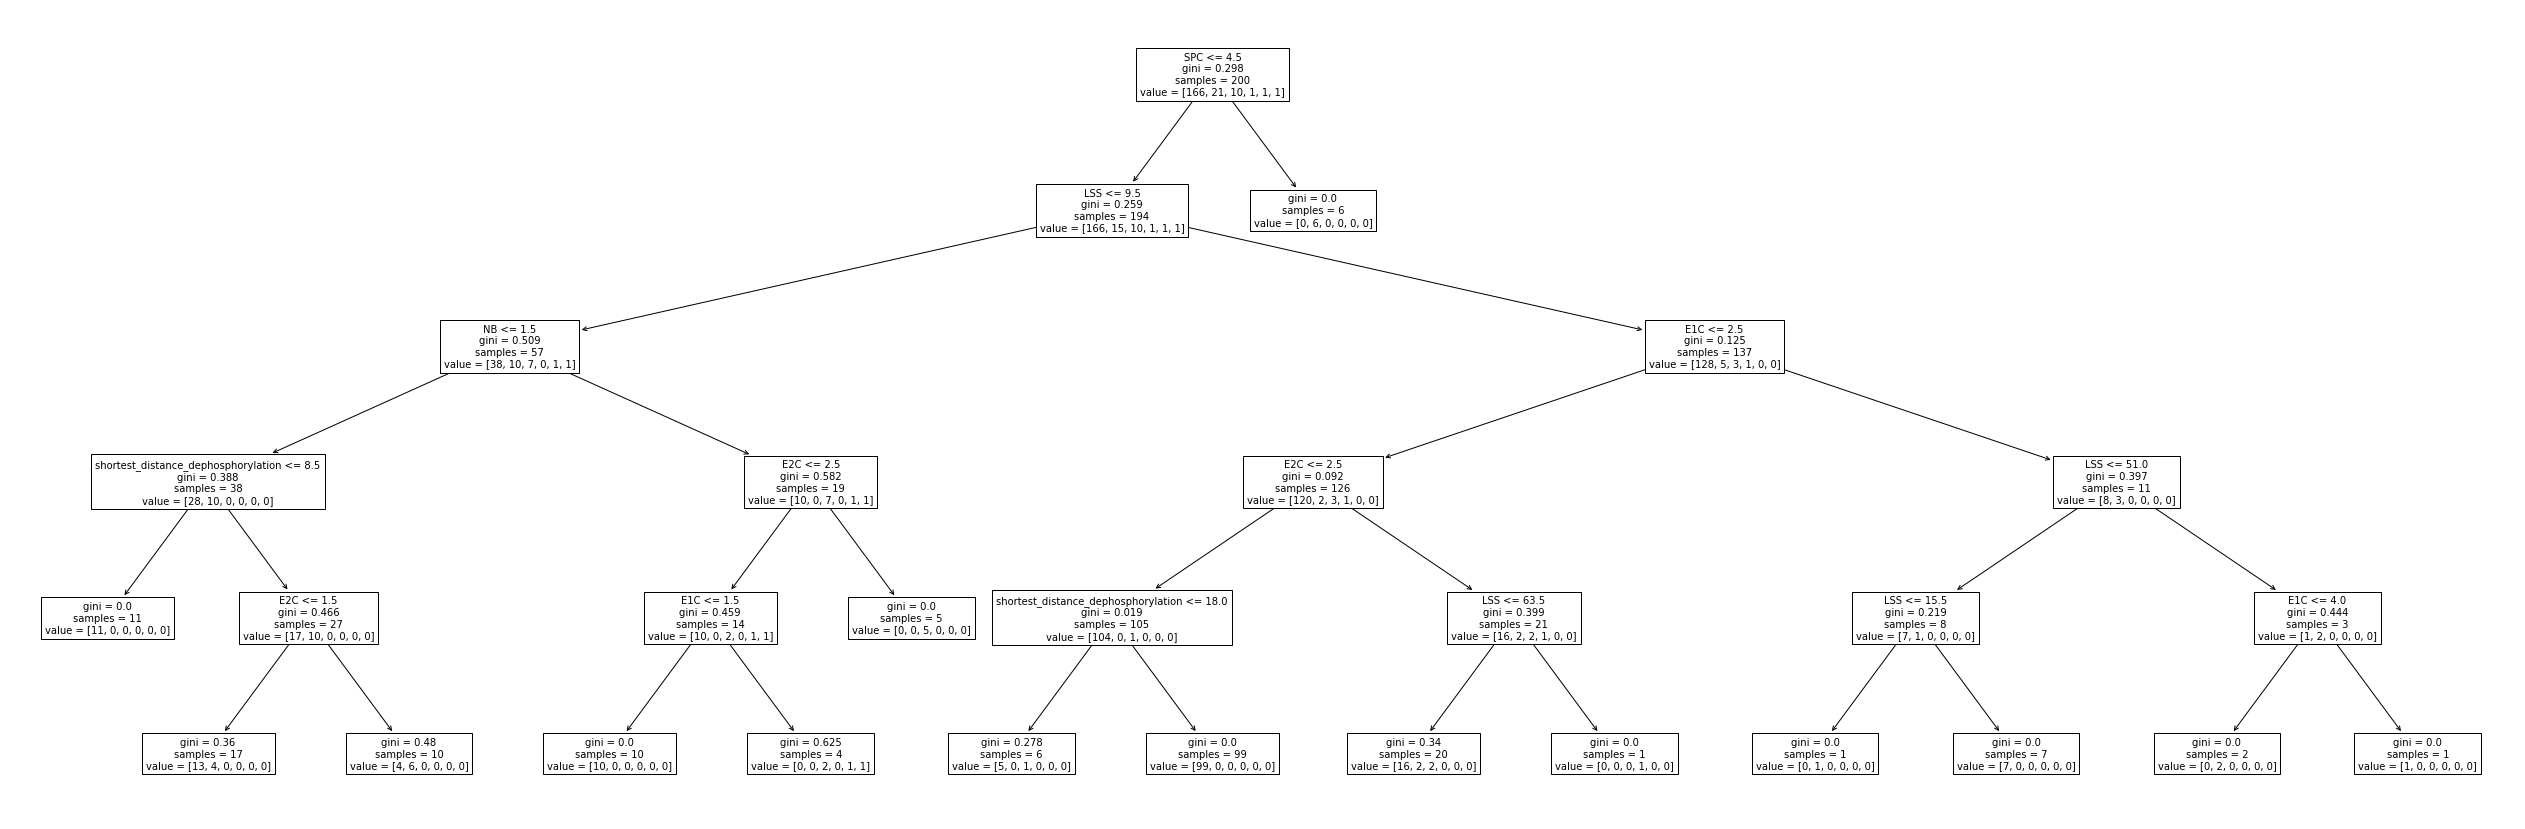

\begin{tabular}{llrrrr}
\toprule
             model &             index & precision & recall & f1-score & support \\
\midrule
       Naive Bayes &   Phosphorylation &      99.9 &   99.2 &     99.5 &    5721 \\
       Naive Bayes & Dephosphorylation &      65.5 &   85.7 &     74.2 &      42 \\
       Naive Bayes &       Methylation &     100.0 &  100.0 &    100.0 &      23 \\
       Naive Bayes &    Ubiquitination &       8.3 &   40.0 &     13.8 &       5 \\
       Naive Bayes &       Acetylation &      27.3 &  100.0 &     42.9 &       3 \\
       Naive Bayes &  Deubiquitination &       0.0 &    0.0 &      0.0 &       0 \\
       Naive Bayes &         micro avg &      99.0 &   99.0 &     99.0 &    5794 \\
       Naive Bayes &         macro avg &      50.2 &   70.8 &     55.1 &    5794 \\
       Naive Bayes &      weighted avg &      99.5 &   99.0 &     99.2 &    5794 \\
Naive Bayes + Tree &   Phosphorylation &      99.9 &  100.0 &     99.9 &    5721 \\
Naive Bayes + Tree & Dephosphoryla

,model,index,precision,recall,f1-score,support
Negative,Naive Bayes,Negative,0.000000,0.000000,0.000000,0.0
Phosphorylation,Naive Bayes,Phosphorylation,0.998592,0.991610,0.995089,5721.0
Dephosphorylation,Naive Bayes,Dephosphorylation,0.654545,0.857143,0.742268,42.0
Methylation,Naive Bayes,Methylation,1.000000,1.000000,1.000000,23.0
Ubiquitination,Naive Bayes,Ubiquitination,0.083333,0.400000,0.137931,5.0
Acetylation,Naive Bayes,Acetylation,0.272727,1.000000,0.428571,3.0
Deubiquitination,Naive Bayes,Deubiquitination,0.000000,0.000000,0.000000,0.0
micro avg,Naive Bayes,micro avg,0.990162,0.990162,0.990162,5794.0
macro avg,Naive Bayes,macro avg,0.429885,0.606965,0.471980,5794.0
weighted avg,Naive Bayes,weighted avg,0.994938,0.990162,0.992242,5794.0


In [16]:
df_largescale_hq = load_large_scale(largescalefile)
result_largescale_hq = train_and_predict_all_classifiers(df_largescale_hq)
plot_tree(result[NAIVE_BAYES_WITH_TREE]["m"])



print_report_all_classifiers(df_largescale_hq["y"], result_largescale_hq, pos_labels)

print_report_all_classifiers(df_largescale_hq["y"], result_largescale_hq, all_labels)



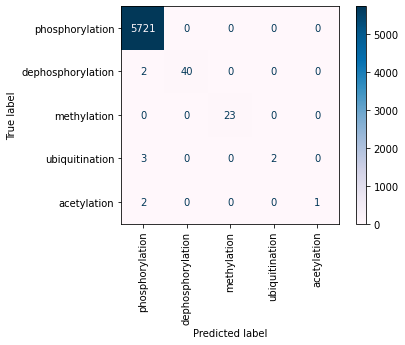

In [17]:
plot_confusionmatrix(df_largescale_hq["y"], result_largescale_hq[NAIVE_BAYES_WITH_TREE]["predictions"])
plt.savefig(os.path.join(temp_dir,"confusionMatrixPTMPHC.png"))

## Fit large scale low quality

In [18]:
df_low_quality = load_large_scale(largescale_low_hq)
low_quality_result = train_and_predict_all_classifiers(df_low_quality)



print_report_all_classifiers(df_largescale_hq["y"], result_largescale_hq, pos_labels)

print_report_all_classifiers(df_largescale_hq["y"], result_largescale_hq, all_labels)




Training Naive Bayes
Max words :  19
Training Naive Bayes + Tree
(6682, 11)
(6682, 11)
Training Tree
(6682, 10)
(6682, 10)
\begin{tabular}{llrrrr}
\toprule
             model &             index & precision & recall & f1-score & support \\
\midrule
       Naive Bayes &   Phosphorylation &      99.9 &   99.2 &     99.5 &    5721 \\
       Naive Bayes & Dephosphorylation &      65.5 &   85.7 &     74.2 &      42 \\
       Naive Bayes &       Methylation &     100.0 &  100.0 &    100.0 &      23 \\
       Naive Bayes &    Ubiquitination &       8.3 &   40.0 &     13.8 &       5 \\
       Naive Bayes &       Acetylation &      27.3 &  100.0 &     42.9 &       3 \\
       Naive Bayes &  Deubiquitination &       0.0 &    0.0 &      0.0 &       0 \\
       Naive Bayes &         micro avg &      99.0 &   99.0 &     99.0 &    5794 \\
       Naive Bayes &         macro avg &      50.2 &   70.8 &     55.1 &    5794 \\
       Naive Bayes &      weighted avg &      99.5 &   99.0 &     99.2 &    579

,model,index,precision,recall,f1-score,support
Negative,Naive Bayes,Negative,0.000000,0.000000,0.000000,0.0
Phosphorylation,Naive Bayes,Phosphorylation,0.998592,0.991610,0.995089,5721.0
Dephosphorylation,Naive Bayes,Dephosphorylation,0.654545,0.857143,0.742268,42.0
Methylation,Naive Bayes,Methylation,1.000000,1.000000,1.000000,23.0
Ubiquitination,Naive Bayes,Ubiquitination,0.083333,0.400000,0.137931,5.0
Acetylation,Naive Bayes,Acetylation,0.272727,1.000000,0.428571,3.0
Deubiquitination,Naive Bayes,Deubiquitination,0.000000,0.000000,0.000000,0.0
micro avg,Naive Bayes,micro avg,0.990162,0.990162,0.990162,5794.0
macro avg,Naive Bayes,macro avg,0.429885,0.606965,0.471980,5794.0
weighted avg,Naive Bayes,weighted avg,0.994938,0.990162,0.992242,5794.0


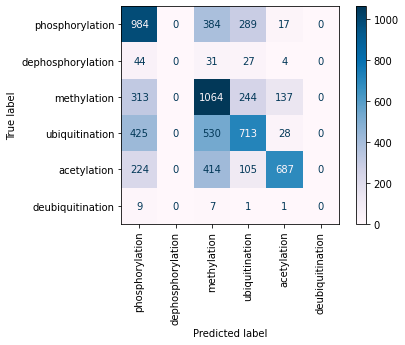

In [19]:
plot_confusionmatrix(df_low_quality["y"], low_quality_result[NAIVE_BAYES_WITH_TREE]["predictions"])

['phosphorylation', 'dephosphorylation', 'methylation', 'ubiquitination', 'acetylation']


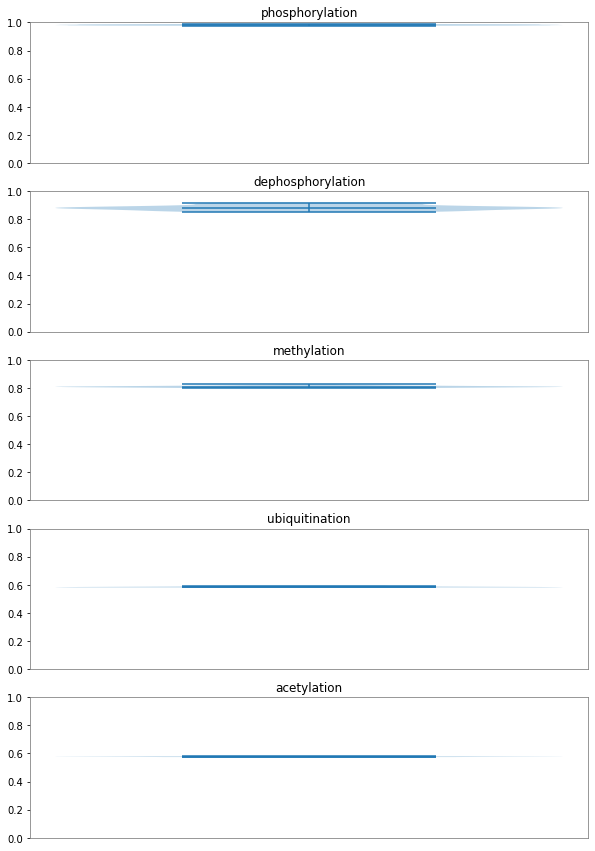

In [20]:
def prep_data(df, m):
    df_t = df.copy(deep=True)
    df_t["nb_pred"] = m["predictions"]
    df_t["nb_pred_conf"] = m["predictions_conf"]
    df_t["nb_pred_raw"] = df_t["nb_pred"].apply(lambda i: label_names[i])
    return df_t

def plot_confidence(df_t):
    labels =  list(df_t["y_raw"].unique())   
    print(labels)
    _ , ax = plt.subplots(len(labels),1, figsize=(10,15))



    for i,l in enumerate(labels):
        t = df_t.query(f"y_raw == '{l}'")

        ax[i].set_ylim(0,1)


        ax[i].tick_params(
            axis='x',          # changes apply to the x-axis
            which='both',      # both major and minor ticks are affected
            bottom=False,      # ticks along the bottom edge are off
            top=False,         # ticks along the top edge are off
            labelbottom=False)

        ax[i].spines['bottom'].set_color('grey')
        ax[i].spines['top'].set_color('grey') 
        ax[i].spines['right'].set_color('grey')
        ax[i].spines['left'].set_color('grey')



        ax[i].violinplot(t["confidence"],  showmeans=True )
        ax[i].set_title(f"{l}")


plot_confidence(prep_data(df_largescale_hq, result_largescale_hq[NAIVE_BAYES_WITH_TREE]))

plt.show()




## Latex results

In [29]:
def prepare_latex(meta_dict_df):
    result = []
    model_names = {NAIVE_BAYES: "NB",
                  NAIVE_BAYES_WITH_TREE:"NBT",
                  TREE : "T"
    }

    for item in meta_dict_df:
        df= item.pop("df")
        df = df.query("index == 'micro avg'").copy(deep=True)
        df["model"] = df["model"].apply(lambda x: model_names[x])
        for i, meta in enumerate(item["meta"]):
            df.insert(i, meta["name"], meta["value"])
        result.append(df)
    df_summ = pd.concat(result)
    df_summ = df_summ.drop("index", axis=1)
    
    return df_summ
    
df_summ_lh_hq_bp = print_report_all_classifiers(df_largescale_hq["y"], result_largescale_hq, pos_labels)

df_summ_test_bp = print_report_all_classifiers(df_test_prediction["y"], result_test_bp, pos_labels)

df_summ_test_gt = print_report_all_classifiers(df_test["y"], result_test_gt, pos_labels)

df_summ_train = print_report_all_classifiers(df_train["y"], train_result, pos_labels)



df_summ = prepare_latex ([
                {"df": df_summ_train, "meta":[{ "name": "dataset" , "value": "PTM TR"}, { "name": "T" , "value": "GT"}]},
                {"df": df_summ_test_gt, "meta":[{ "name": "dataset" , "value": "PTM TS"}, { "name": "T" , "value": "GT"}]},
                {"df": df_summ_test_bp, "meta":[{ "name": "dataset" , "value": "PTM TS"}, { "name": "T" , "value": "BP"}]},
                {"df": df_summ_lh_hq_bp, "meta":[{ "name": "dataset" , "value": "PTM LH"}, { "name": "T" , "value": "BP"}]}
                ]
              )

print(df_summ.to_latex(index=False, formatters = {"precision": float_percent_format, "recall":float_percent_format, "f1-score":float_percent_format,"support":int_format}))

\begin{tabular}{llrrrr}
\toprule
             model &             index & precision & recall & f1-score & support \\
\midrule
       Naive Bayes &   Phosphorylation &      99.9 &   99.2 &     99.5 &    5721 \\
       Naive Bayes & Dephosphorylation &      65.5 &   85.7 &     74.2 &      42 \\
       Naive Bayes &       Methylation &     100.0 &  100.0 &    100.0 &      23 \\
       Naive Bayes &    Ubiquitination &       8.3 &   40.0 &     13.8 &       5 \\
       Naive Bayes &       Acetylation &      27.3 &  100.0 &     42.9 &       3 \\
       Naive Bayes &  Deubiquitination &       0.0 &    0.0 &      0.0 &       0 \\
       Naive Bayes &         micro avg &      99.0 &   99.0 &     99.0 &    5794 \\
       Naive Bayes &         macro avg &      50.2 &   70.8 &     55.1 &    5794 \\
       Naive Bayes &      weighted avg &      99.5 &   99.0 &     99.2 &    5794 \\
Naive Bayes + Tree &   Phosphorylation &      99.9 &  100.0 &     99.9 &    5721 \\
Naive Bayes + Tree & Dephosphoryla

In [30]:
def prepare_latex(meta_dict_df):
    result = []
    model_names = {NAIVE_BAYES: "NB",
                  NAIVE_BAYES_WITH_TREE:"NBT",
                  TREE : "T"
    }

    for item in meta_dict_df:
        df= item.pop("df")
        df = df.copy(deep=True)
        df["model"] = df["model"].apply(lambda x: model_names[x])
        for i, meta in enumerate(item["meta"]):
            df.insert(i, meta["name"], meta["value"])
        result.append(df)
    df_summ = pd.concat(result)
    df_summ["index"] = df_summ["index"].apply(lambda x: label_names[int(x)] if isint(x) else x )
    
    return df_summ

df_summ_lh_hq_bp = print_report_all_classifiers(df_largescale_hq["y"], result_largescale_hq, all_labels)

df_summ_test_bp = print_report_all_classifiers(df_test_prediction["y"], result_test_bp, all_labels)

df_summ_test_gt = print_report_all_classifiers(df_test["y"], result_test_gt, all_labels)

df_summ_train = print_report_all_classifiers(df_train["y"], train_result, all_labels)



df_summ = prepare_latex ([
                {"df": df_summ_train, "meta":[{ "name": "dataset" , "value": "PTM TR"}, { "name": "T" , "value": "GT"}]},
                {"df": df_summ_test_gt, "meta":[{ "name": "dataset" , "value": "PTM TS"}, { "name": "T" , "value": "GT"}]},
                {"df": df_summ_test_bp, "meta":[{ "name": "dataset" , "value": "PTM TS"}, { "name": "T" , "value": "BP"}]},
                {"df": df_summ_lh_hq_bp, "meta":[{ "name": "dataset" , "value": "PTM LH"}, { "name": "T" , "value": "BP"}]}
                ]
              )

print(df_summ.to_latex(index=False, formatters = {"precision": float_percent_format, "recall":float_percent_format, "f1-score":float_percent_format,"support":int_format}))

\begin{tabular}{llrrrr}
\toprule
             model &             index & precision & recall & f1-score & support \\
\midrule
       Naive Bayes &          Negative &       0.0 &    0.0 &      0.0 &       0 \\
       Naive Bayes &   Phosphorylation &      99.9 &   99.2 &     99.5 &    5721 \\
       Naive Bayes & Dephosphorylation &      65.5 &   85.7 &     74.2 &      42 \\
       Naive Bayes &       Methylation &     100.0 &  100.0 &    100.0 &      23 \\
       Naive Bayes &    Ubiquitination &       8.3 &   40.0 &     13.8 &       5 \\
       Naive Bayes &       Acetylation &      27.3 &  100.0 &     42.9 &       3 \\
       Naive Bayes &  Deubiquitination &       0.0 &    0.0 &      0.0 &       0 \\
       Naive Bayes &         micro avg &      99.0 &   99.0 &     99.0 &    5794 \\
       Naive Bayes &         macro avg &      43.0 &   60.7 &     47.2 &    5794 \\
       Naive Bayes &      weighted avg &      99.5 &   99.0 &     99.2 &    5794 \\
Naive Bayes + Tree &          Nega